In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

def load_lc(folder_path, n, balance = True):
    light_curves = []
    targets = []
    for target in os.listdir(folder_path):
        target_path = os.path.join(folder_path, target)
        if os.path.isdir(target_path):
            if balance:
                if len(os.listdir(target_path))>=n:
                    i = 0
                    for file in tqdm(os.listdir(target_path), desc=target):
                        if i < n+1:
                            file_path = os.path.join(target_path, file)
                            if file.endswith(".dat"):
                                i += 1
                                data = pd.read_csv(file_path, sep='\s+', names=['mjd', 'mag', 'mag_err'])
                                data.replace([np.inf, -np.inf], np.nan, inplace=True)
                                data.dropna(inplace=True)
                                light_curves.append(data[['mjd', 'mag', 'mag_err']].values)
                                targets.append(target)
            else:
                i = 0
                for file in tqdm(os.listdir(target_path), desc=target):
                    if i < n+1:
                        file_path = os.path.join(target_path, file)
                        if file.endswith(".dat"):
                            i += 1
                            data = pd.read_csv(file_path, sep='\s+', names=['mjd', 'mag', 'mag_err'])
                            data.replace([np.inf, -np.inf], np.nan, inplace=True)
                            data.dropna(inplace=True)
                            light_curves.append(data[['mjd', 'mag', 'mag_err']].values)
                            targets.append(target)

                    

    return light_curves, targets

def preprocessing(light_curves, targets, scaler=MinMaxScaler()):
#     label_encoder = LabelEncoder()
#     targets_codif = label_encoder.fit_transform(targets)
    
    light_curves_norm = [np.array([scaler.fit_transform(feature.reshape(-1, 1)).T[0] for feature in curve.T]).T for curve in light_curves]
    
    max_length = max(len(seq) for seq in light_curves_norm)
    X_padded = tf.keras.preprocessing.sequence.pad_sequences(light_curves_norm, padding='post', maxlen=max_length, dtype='float32')
    
    X_train, X_temp, y_train, y_temp = train_test_split(X_padded, targets, test_size=0.2, random_state=42, shuffle=True)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

    X_train = np.transpose(X_train, (0, 2, 1))
    X_val = np.transpose(X_val, (0, 2, 1))
    X_test = np.transpose(X_test, (0, 2, 1))

    encoder = OneHotEncoder(sparse_output=False)
    y_train_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
    y_val_encoded = encoder.transform(np.array(y_val).reshape(-1, 1))
    y_test_encoded = encoder.transform(np.array(y_test).reshape(-1, 1))
    return X_train, X_val, X_test, y_train_encoded, y_val_encoded, y_test_encoded, max_length, encoder

# Model evaluation
def model_evaluate(history, model_path, X_test, y_test):
    saved_model = load_model(model_path)
    test_loss, test_accuracy = saved_model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'],"-o",  label='Training Loss')
    plt.plot(history.history['val_loss'], "-o", label='Validation Loss')
    plt.title('Loss function')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], "-o", label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], "-o" , label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

def cm(X_test, y_test, model, classes,  name = "Matriz de confusión", save_path=None):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, values_format='.2f')
    plt.title(name)
    plt.xticks(rotation=45, ha='right')
    if save_path is not None:
        plt.savefig(save_path)


def cm_grouped(X_test, y_test, model, classes, name = "Matriz de confusión" , save_path=None):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    grouped_y_test_classes = np.array([label if not label.startswith('uLens') else 'uLens' for label in classes])
    grouped_y_pred_classes = np.array([label if not label.startswith('uLens') else 'uLens' for label in classes])
    grouped_y_test_classes = np.array([label if (label in ["Constant", "uLens"]) else 'Variable' for label in grouped_y_test_classes])
    grouped_y_pred_classes = np.array([label if (label in ["Constant", "uLens"]) else 'Variable' for label in grouped_y_pred_classes])
    conf_matrix = confusion_matrix(grouped_y_test_classes[y_test_classes], grouped_y_pred_classes[y_pred_classes], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(grouped_y_test_classes))
    disp.plot(cmap=plt.cm.Blues, values_format='.2f')
    plt.title('Matriz de Confusión')
    plt.xticks(rotation=45, ha='right')
    grouped_accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
    print(f'Accuracy Agrupada: {grouped_accuracy:.2%}')
    if save_path is not None:
        plt.savefig(save_path)

Variables:
* Problema
    * Multicategórico
    * Multicategórico unificado (Cepheid, RNN, ..., uLens)
    * Binario (No_uLens; uLens)
* Arquitectura
    * Intercalar LSTM con densas
    * Agregar Bidireccional aunque no sirva para despues?
* Cantidad de capas
* Cantidad de neuronas por capa
* Learning_rate
* Loop_back
* Cantidad de datos
* Normalización
* OneHot / sparse_categorical_crossentropy

EB: 100%|██████████| 39415/39415 [00:17<00:00, 2255.19it/s]
Mdwarf-flare: 0it [00:00, ?it/s]
Constant: 100%|██████████| 6282/6282 [00:14<00:00, 439.16it/s] 


Epoch 1/100
416/416 [==============================] - ETA: 0s - loss: 1.6347 - accuracy: 0.3344
Epoch 1: val_loss improved from inf to 1.38067, saving model to best_model.h5
416/416 [==============================] - 20s 21ms/step - loss: 1.6347 - accuracy: 0.3344 - val_loss: 1.3807 - val_accuracy: 0.4067
Epoch 2/100
415/416 [============================>.] - ETA: 0s - loss: 1.3144 - accuracy: 0.4331
Epoch 2: val_loss improved from 1.38067 to 1.22624, saving model to best_model.h5
416/416 [==============================] - 4s 10ms/step - loss: 1.3145 - accuracy: 0.4329 - val_loss: 1.2262 - val_accuracy: 0.4531
Epoch 3/100
414/416 [============================>.] - ETA: 0s - loss: 1.1956 - accuracy: 0.4713
Epoch 3: val_loss improved from 1.22624 to 1.15738, saving model to best_model.h5
416/416 [==============================] - 4s 10ms/step - loss: 1.1958 - accuracy: 0.4713 - val_loss: 1.1574 - val_accuracy: 0.4675
Epoch 4/100
411/416 [============================>.] - ETA: 0s - loss:

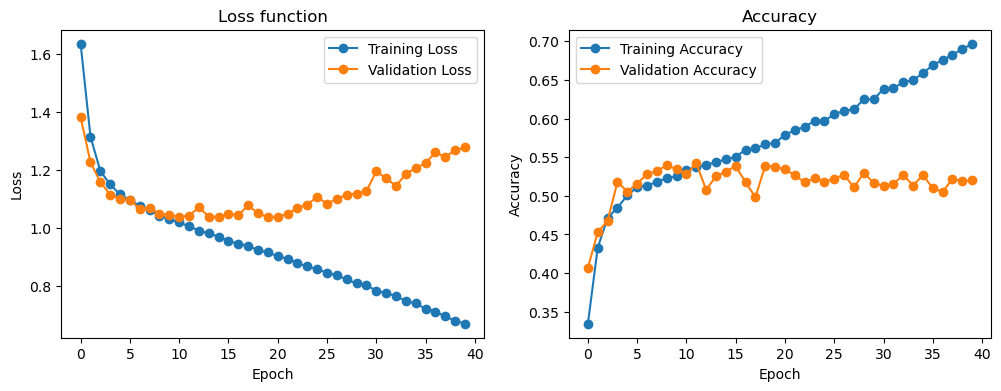

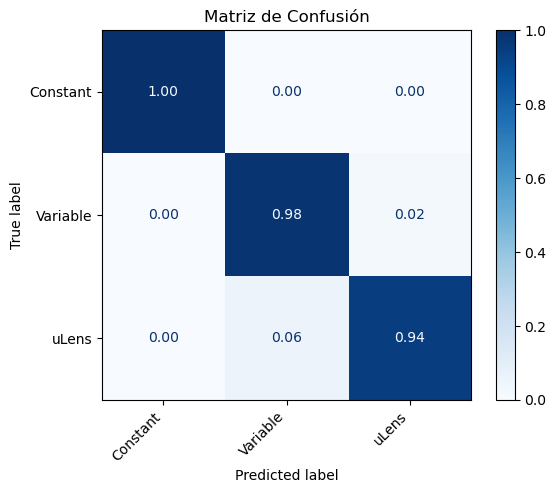

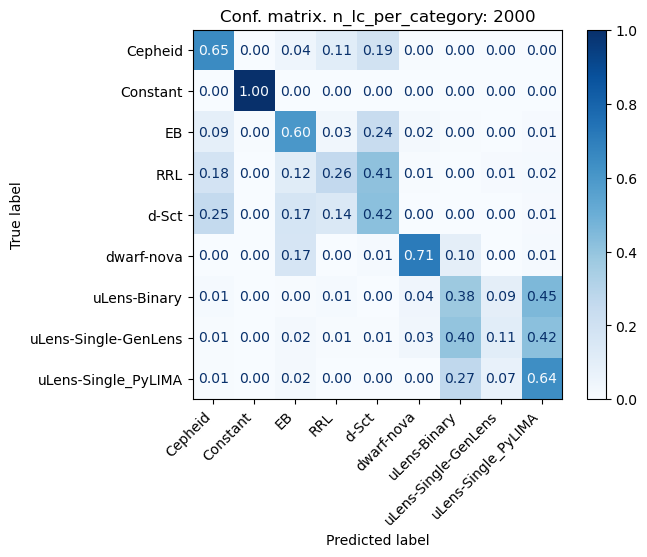

In [20]:
# 2000 lc per category. Balance=False
n_lc_per_category = 2000
carpeta_datos = "Classifier_2/DataSets/ELASTICC2_i_Valid_Chi_Constant" #'ELASTICC2_i_filtered'
light_curves, targets = load_lc(carpeta_datos, n_lc_per_category)
X_train, X_val, X_test, y_train, y_val, y_test, max_length, encoder = preprocessing(light_curves, targets)

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
max_length = max(len(seq) for seq in light_curves)
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(3, max_length)))

# ...........
model.add(LSTM(50, return_sequences=True))
model.add(Dense(50, activation='relu'))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
# ..........

model.add(Dense(len(encoder.categories_[0]), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])
model_evaluate(history, "best_model.h5", X_test, y_test)

best_model = load_model("best_model.h5")
cm_grouped(X_test, y_test, best_model, encoder.categories_[0], name = f"Grouped conf. matrix. n_lc_per_category: {n_lc_per_category}")
cm(X_test, y_test, best_model, encoder.categories_[0], name = f"Conf. matrix. n_lc_per_category: {n_lc_per_category}")




Constant: 100%|██████████| 6282/6282 [00:21<00:00, 288.41it/s]


Epoch 1/100
522/526 [============================>.] - ETA: 0s - loss: 1.3112 - accuracy: 0.4271
Epoch 1: val_loss improved from inf to 1.17797, saving model to best_model.h5
526/526 [==============================] - 21s 16ms/step - loss: 1.3109 - accuracy: 0.4272 - val_loss: 1.1780 - val_accuracy: 0.4826
Epoch 2/100
523/526 [============================>.] - ETA: 0s - loss: 1.0925 - accuracy: 0.5132
Epoch 2: val_loss improved from 1.17797 to 1.07840, saving model to best_model.h5
526/526 [==============================] - 6s 11ms/step - loss: 1.0920 - accuracy: 0.5134 - val_loss: 1.0784 - val_accuracy: 0.5288
Epoch 3/100
520/526 [============================>.] - ETA: 0s - loss: 1.0032 - accuracy: 0.5546
Epoch 3: val_loss improved from 1.07840 to 1.01720, saving model to best_model.h5
526/526 [==============================] - 5s 10ms/step - loss: 1.0024 - accuracy: 0.5550 - val_loss: 1.0172 - val_accuracy: 0.5535
Epoch 4/100
522/526 [============================>.] - ETA: 0s - loss:

526/526 [==============================] - 5s 9ms/step - loss: 0.6696 - accuracy: 0.6960 - val_loss: 1.0006 - val_accuracy: 0.5735
Epoch 30/100
525/526 [============================>.] - ETA: 0s - loss: 0.6648 - accuracy: 0.7010
Epoch 30: val_loss did not improve from 0.88057
526/526 [==============================] - 5s 9ms/step - loss: 0.6649 - accuracy: 0.7009 - val_loss: 0.9742 - val_accuracy: 0.5750
Epoch 31/100
522/526 [============================>.] - ETA: 0s - loss: 0.6439 - accuracy: 0.7058
Epoch 31: val_loss did not improve from 0.88057
526/526 [==============================] - 5s 9ms/step - loss: 0.6440 - accuracy: 0.7054 - val_loss: 0.9828 - val_accuracy: 0.5878
Epoch 32/100
522/526 [============================>.] - ETA: 0s - loss: 0.6358 - accuracy: 0.7127
Epoch 32: val_loss did not improve from 0.88057
526/526 [==============================] - 5s 9ms/step - loss: 0.6350 - accuracy: 0.7129 - val_loss: 0.9925 - val_accuracy: 0.5835
Epoch 33/100
521/526 [================

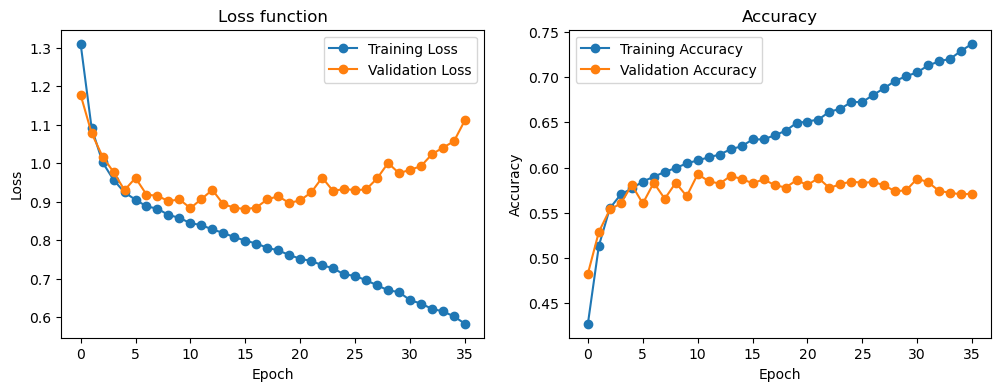

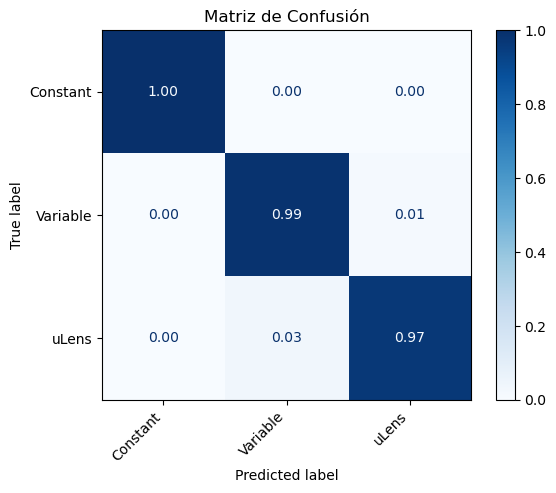

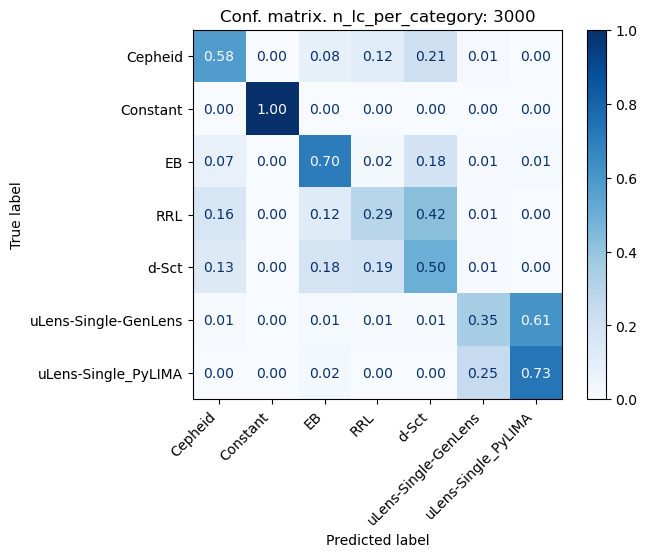

In [24]:
# 2000 lc per category. Balance=True
n_lc_per_category = 3000
carpeta_datos = "Classifier_2/DataSets/ELASTICC2_i_Valid_Chi_Constant" #'ELASTICC2_i_filtered'
light_curves, targets = load_lc(carpeta_datos, n_lc_per_category)
X_train, X_val, X_test, y_train, y_val, y_test, max_length, encoder = preprocessing(light_curves, targets)

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
max_length = max(len(seq) for seq in light_curves)
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(3, max_length)))

# ...........
model.add(LSTM(50, return_sequences=True))
model.add(Dense(50, activation='relu'))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
# ..........

model.add(Dense(len(encoder.categories_[0]), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])
model_evaluate(history, "best_model.h5", X_test, y_test)

best_model = load_model("best_model.h5")
cm_grouped(X_test, y_test, best_model, encoder.categories_[0], name = f"Grouped conf. matrix. n_lc_per_category: {n_lc_per_category}")
cm(X_test, y_test, best_model, encoder.categories_[0], name = f"Conf. matrix. n_lc_per_category: {n_lc_per_category}")




EB: 100%|██████████| 39415/39415 [00:18<00:00, 2161.55it/s] 
Mdwarf-flare: 0it [00:00, ?it/s]
Constant: 100%|██████████| 6282/6282 [00:16<00:00, 370.56it/s]


Epoch 1/100
587/591 [============================>.] - ETA: 0s - loss: 1.5772 - accuracy: 0.3564
Epoch 1: val_loss improved from inf to 1.31201, saving model to best_model.h5
591/591 [==============================] - 22s 16ms/step - loss: 1.5758 - accuracy: 0.3566 - val_loss: 1.3120 - val_accuracy: 0.4568
Epoch 2/100
591/591 [==============================] - ETA: 0s - loss: 1.2651 - accuracy: 0.4653
Epoch 2: val_loss improved from 1.31201 to 1.16161, saving model to best_model.h5
591/591 [==============================] - 6s 10ms/step - loss: 1.2651 - accuracy: 0.4653 - val_loss: 1.1616 - val_accuracy: 0.5047
Epoch 3/100
591/591 [==============================] - ETA: 0s - loss: 1.1630 - accuracy: 0.4980
Epoch 3: val_loss improved from 1.16161 to 1.09490, saving model to best_model.h5
591/591 [==============================] - 6s 10ms/step - loss: 1.1630 - accuracy: 0.4980 - val_loss: 1.0949 - val_accuracy: 0.5275
Epoch 4/100
589/591 [============================>.] - ETA: 0s - loss:

Epoch 30/100
587/591 [============================>.] - ETA: 0s - loss: 0.7751 - accuracy: 0.6514
Epoch 30: val_loss did not improve from 1.00423
591/591 [==============================] - 5s 9ms/step - loss: 0.7754 - accuracy: 0.6513 - val_loss: 1.0819 - val_accuracy: 0.5542
Epoch 31/100
588/591 [============================>.] - ETA: 0s - loss: 0.7699 - accuracy: 0.6530
Epoch 31: val_loss did not improve from 1.00423
591/591 [==============================] - 5s 9ms/step - loss: 0.7696 - accuracy: 0.6530 - val_loss: 1.1304 - val_accuracy: 0.5373
Epoch 32/100
588/591 [============================>.] - ETA: 0s - loss: 0.7524 - accuracy: 0.6635
Epoch 32: val_loss did not improve from 1.00423
591/591 [==============================] - 5s 9ms/step - loss: 0.7525 - accuracy: 0.6632 - val_loss: 1.1169 - val_accuracy: 0.5406
Epoch 33/100
588/591 [============================>.] - ETA: 0s - loss: 0.7373 - accuracy: 0.6714
Epoch 33: val_loss did not improve from 1.00423
591/591 [==============

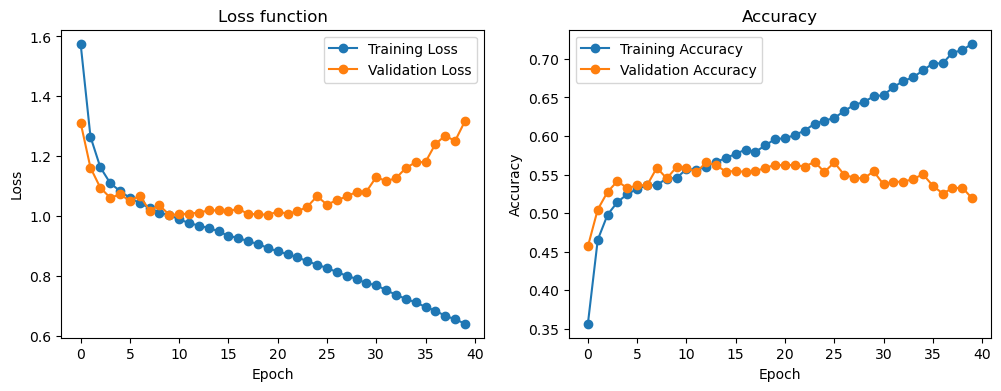

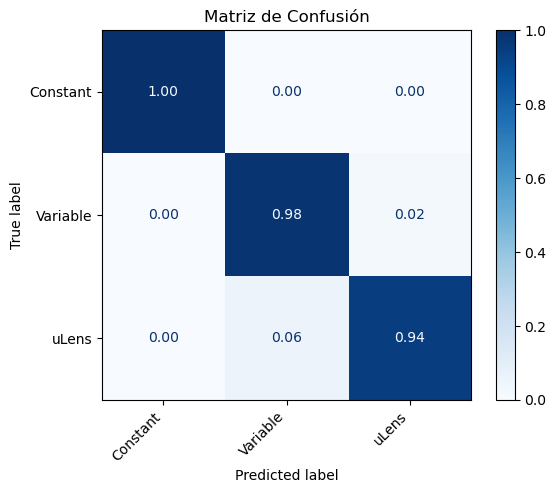

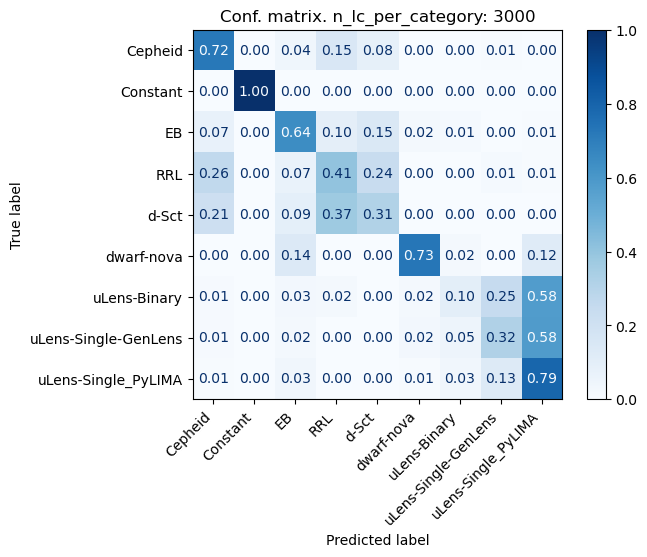

In [27]:
# 3000 lc per category. Balance=False
n_lc_per_category = 3000
carpeta_datos = "Classifier_2/DataSets/ELASTICC2_i_Valid_Chi_Constant" #'ELASTICC2_i_filtered'
light_curves, targets = load_lc(carpeta_datos, n_lc_per_category, balance=False)
X_train, X_val, X_test, y_train, y_val, y_test, max_length, encoder = preprocessing(light_curves, targets)

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
max_length = max(len(seq) for seq in light_curves)
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(3, max_length)))

# ...........
model.add(LSTM(50, return_sequences=True))
model.add(Dense(50, activation='relu'))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
# ..........

model.add(Dense(len(encoder.categories_[0]), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])
model_evaluate(history, "best_model.h5", X_test, y_test)

best_model = load_model("best_model.h5")
cm_grouped(X_test, y_test, best_model, encoder.categories_[0], name = f"Grouped conf. matrix. n_lc_per_category: {n_lc_per_category}")
cm(X_test, y_test, best_model, encoder.categories_[0], name = f"Conf. matrix. n_lc_per_category: {n_lc_per_category}")




Constant: 100%|██████████| 1000/1000 [00:04<00:00, 208.00it/s]


Epoch 1/100
196/200 [============================>.] - ETA: 0s - loss: 1.7519 - accuracy: 0.2919
Epoch 1: val_loss improved from inf to 1.64177, saving model to best_model.h5
200/200 [==============================] - 13s 23ms/step - loss: 1.7508 - accuracy: 0.2931 - val_loss: 1.6418 - val_accuracy: 0.2962
Epoch 2/100
195/200 [============================>.] - ETA: 0s - loss: 1.5470 - accuracy: 0.3479
Epoch 2: val_loss improved from 1.64177 to 1.59810, saving model to best_model.h5
200/200 [==============================] - 2s 8ms/step - loss: 1.5466 - accuracy: 0.3486 - val_loss: 1.5981 - val_accuracy: 0.3262
Epoch 3/100
196/200 [============================>.] - ETA: 0s - loss: 1.4659 - accuracy: 0.3693
Epoch 3: val_loss improved from 1.59810 to 1.47322, saving model to best_model.h5
200/200 [==============================] - 2s 8ms/step - loss: 1.4663 - accuracy: 0.3694 - val_loss: 1.4732 - val_accuracy: 0.3713
Epoch 4/100
194/200 [============================>.] - ETA: 0s - loss: 1

195/200 [============================>.] - ETA: 0s - loss: 0.9674 - accuracy: 0.5470
Epoch 29: val_loss improved from 1.16104 to 1.16049, saving model to best_model.h5
200/200 [==============================] - 2s 8ms/step - loss: 0.9660 - accuracy: 0.5480 - val_loss: 1.1605 - val_accuracy: 0.4238
Epoch 30/100
195/200 [============================>.] - ETA: 0s - loss: 0.9648 - accuracy: 0.5494
Epoch 30: val_loss did not improve from 1.16049
200/200 [==============================] - 1s 7ms/step - loss: 0.9666 - accuracy: 0.5480 - val_loss: 1.2016 - val_accuracy: 0.4225
Epoch 31/100
193/200 [===========================>..] - ETA: 0s - loss: 0.9556 - accuracy: 0.5518
Epoch 31: val_loss did not improve from 1.16049
200/200 [==============================] - 2s 8ms/step - loss: 0.9552 - accuracy: 0.5519 - val_loss: 1.1636 - val_accuracy: 0.4450
Epoch 32/100
200/200 [==============================] - ETA: 0s - loss: 0.9509 - accuracy: 0.5558
Epoch 32: val_loss did not improve from 1.16049
2

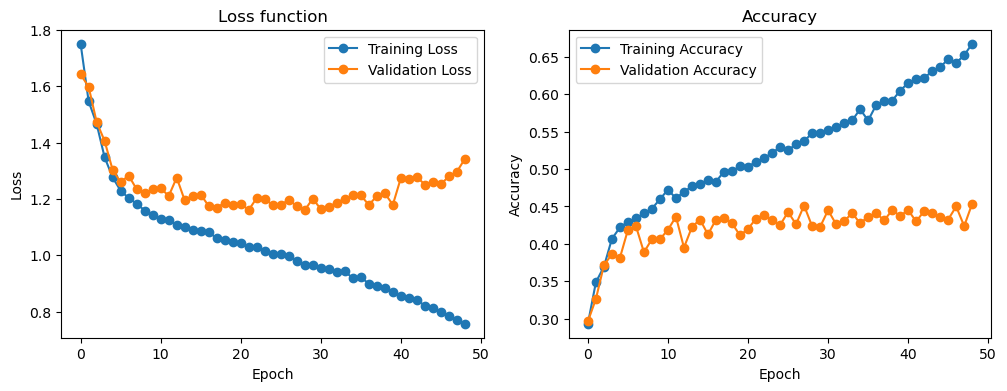

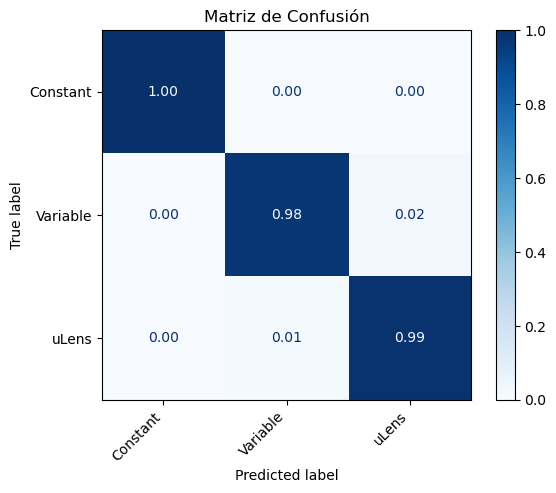

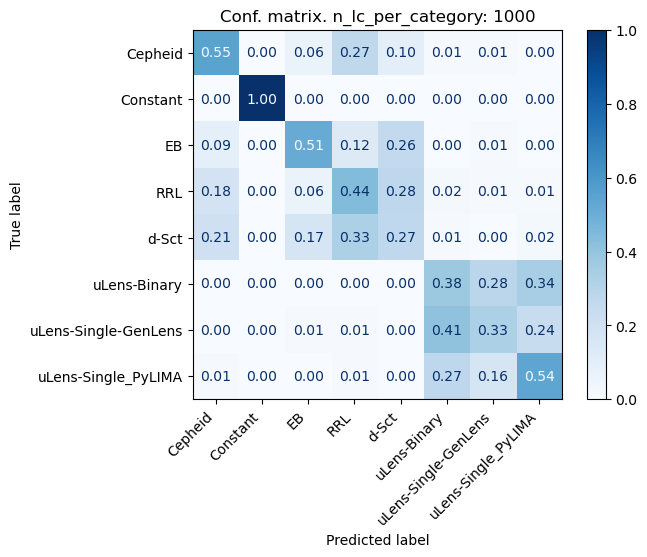

In [18]:
# 2000 lc per category. Balance=True. Daniel's dataset
n_lc_per_category = 1000
carpeta_datos = 'ELASTICC2_i_filtered'# "Classifier_2/DataSets/ELASTICC2_i_Valid_Chi_Constant" #'ELASTICC2_i_filtered'
light_curves, targets = load_lc(carpeta_datos, n_lc_per_category)
X_train, X_val, X_test, y_train, y_val, y_test, max_length, encoder = preprocessing(light_curves, targets)

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
max_length = max(len(seq) for seq in light_curves)
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(3, max_length)))

# ...........
model.add(LSTM(50, return_sequences=True))
model.add(Dense(50, activation='relu'))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
# ..........

model.add(Dense(len(encoder.categories_[0]), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])
model_evaluate(history, "best_model.h5", X_test, y_test)

best_model = load_model("best_model.h5")
cm_grouped(X_test, y_test, best_model, encoder.categories_[0], name = f"Grouped conf. matrix. n_lc_per_category: {n_lc_per_category}")
cm(X_test, y_test, best_model, encoder.categories_[0], name = f"Conf. matrix. n_lc_per_category: {n_lc_per_category}")




25/25 [==============================] - 3s 4ms/step - loss: 1.0663 - accuracy: 0.4787
Test Loss: 1.0662671327590942, Test Accuracy: 0.47874999046325684
25/25 [==============================] - 3s 3ms/step
Accuracy Agrupada: 98.77%
25/25 [==============================] - 0s 3ms/step


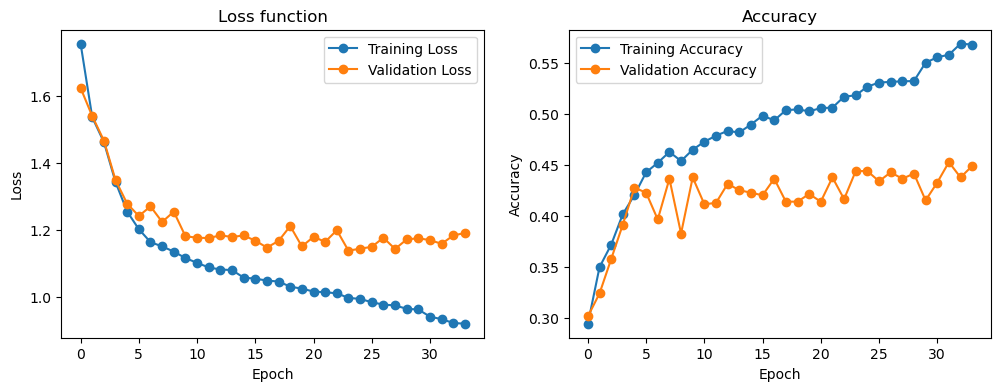

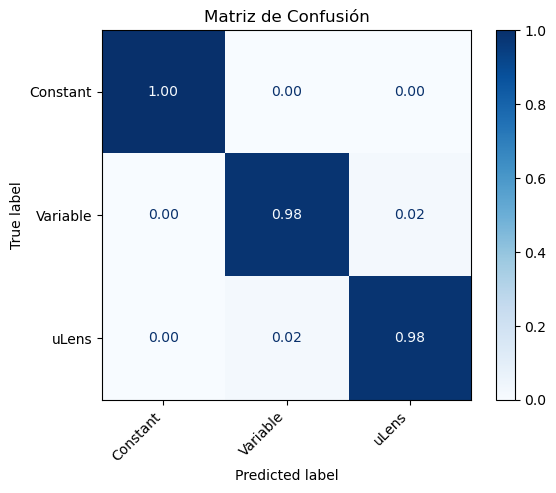

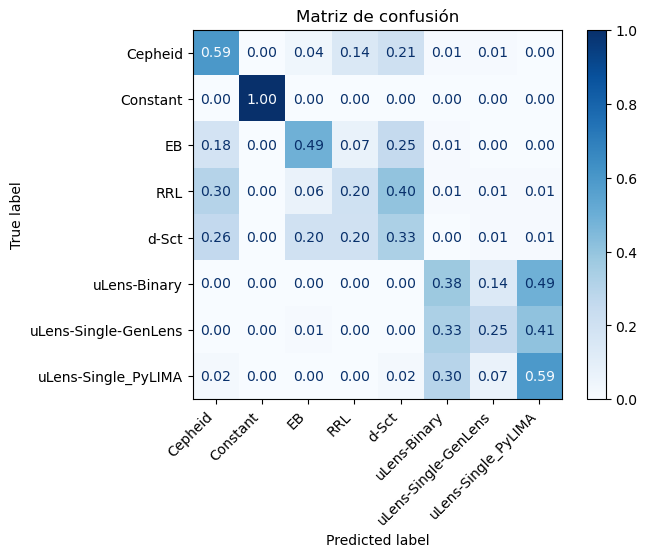

In [17]:
model_evaluate(history, "best_model.h5", X_test, y_test)

best_model = load_model("best_model.h5")
cm_grouped(X_test, y_test, best_model, encoder.categories_[0])
cm(X_test, y_test, best_model, encoder.categories_[0])

In [ ]:
model.summary()

In [123]:

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(3, max_length)))

# model.add(LSTM(80, return_sequences=True))
# model.add(LSTM(80, return_sequences=True))
# model.add(Dense(80, activation='relu'))
# model.add(LSTM(50))
# model.add(Dense(len(label_encoder.classes_), activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.add(LSTM(50, return_sequences=True))
model.add(Dense(50, activation='relu'))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))


# model.add(Bidirectional(LSTM(200, return_sequences=True)))
# model.add(Dropout(0.2))  # Agregar dropout
# model.add(Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(0.1))))
# model.add(Dropout(0.2))  # Agregar dropout
# model.add(LSTM(200, return_sequences=True, kernel_regularizer=l2(0.1)))
# model.add(Dropout(0.2))  # Agregar dropout
# # model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))  # Capa intermedia Dense con activación ReLU
# model.add(Bidirectional(LSTM(50)))
# model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.add(Dense(len(label_encoder.classes_), activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])


history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_val, y_val_encoded), callbacks=[checkpoint, early_stopping])


Epoch 1/50
195/200 [============================>.] - ETA: 0s - loss: 1.7948 - accuracy: 0.2665
Epoch 1: val_loss improved from inf to 1.67073, saving model to best_model.h5
200/200 [==============================] - 12s 19ms/step - loss: 1.7910 - accuracy: 0.2675 - val_loss: 1.6707 - val_accuracy: 0.3088
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 1.5626 - accuracy: 0.3528
Epoch 2: val_loss improved from 1.67073 to 1.56049, saving model to best_model.h5
200/200 [==============================] - 1s 7ms/step - loss: 1.5626 - accuracy: 0.3528 - val_loss: 1.5605 - val_accuracy: 0.3487
Epoch 3/50
194/200 [============================>.] - ETA: 0s - loss: 1.4621 - accuracy: 0.3779
Epoch 3: val_loss improved from 1.56049 to 1.49823, saving model to best_model.h5
200/200 [==============================] - 1s 7ms/step - loss: 1.4599 - accuracy: 0.3778 - val_loss: 1.4982 - val_accuracy: 0.3462
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 1.334

Epoch 29/50
195/200 [============================>.] - ETA: 0s - loss: 0.9558 - accuracy: 0.5545
Epoch 29: val_loss did not improve from 1.13294
200/200 [==============================] - 1s 7ms/step - loss: 0.9555 - accuracy: 0.5552 - val_loss: 1.1424 - val_accuracy: 0.4350
Epoch 30/50
198/200 [============================>.] - ETA: 0s - loss: 0.9470 - accuracy: 0.5603
Epoch 30: val_loss did not improve from 1.13294
200/200 [==============================] - 1s 6ms/step - loss: 0.9477 - accuracy: 0.5597 - val_loss: 1.1330 - val_accuracy: 0.4588
Epoch 31/50
191/200 [===========================>..] - ETA: 0s - loss: 0.9433 - accuracy: 0.5664
Epoch 31: val_loss improved from 1.13294 to 1.13207, saving model to best_model.h5
200/200 [==============================] - 1s 7ms/step - loss: 0.9451 - accuracy: 0.5656 - val_loss: 1.1321 - val_accuracy: 0.4512
Epoch 32/50
198/200 [============================>.] - ETA: 0s - loss: 0.9310 - accuracy: 0.5775
Epoch 32: val_loss did not improve from 

25/25 [==============================] - 3s 3ms/step - loss: 1.0856 - accuracy: 0.4913
Test Loss: 1.0856070518493652, Test Accuracy: 0.49125000834465027


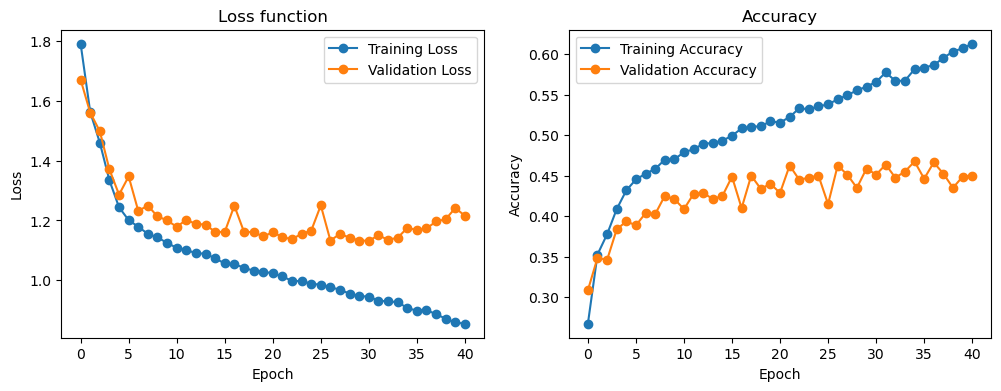

In [124]:
# Model evaluation
def model_evaluate(history, model_path, X_test, y_test):
    saved_model = load_model(model_path)
    test_loss, test_accuracy = saved_model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'],"-o",  label='Training Loss')
    plt.plot(history.history['val_loss'], "-o", label='Validation Loss')
    plt.title('Loss function')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], "-o", label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], "-o" , label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
model_evaluate(history, "best_model.h5", X_test, y_test_encoded)

25/25 [==============================] - 3s 4ms/step - loss: 1.1710 - accuracy: 0.4563
Test Loss: 1.1710247993469238, Test Accuracy: 0.45625001192092896


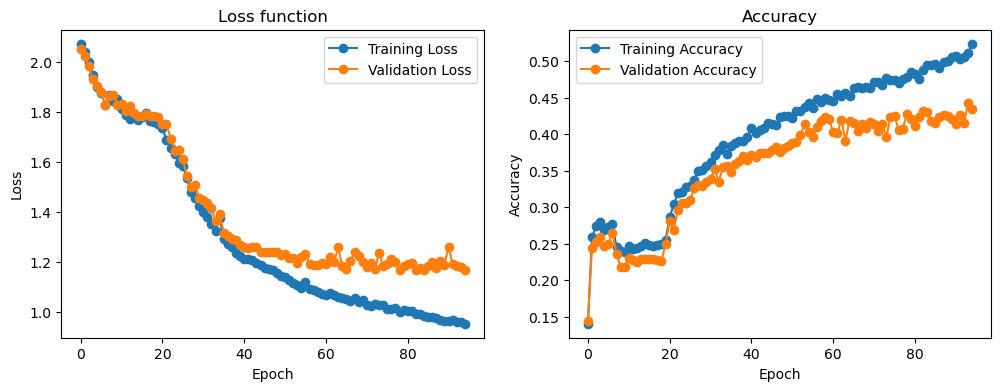

In [16]:
# Model evaluation
def model_evaluate(history, model_path, X_test, y_test):
    saved_model = load_model(model_path)
    test_loss, test_accuracy = saved_model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'],"-o",  label='Training Loss')
    plt.plot(history.history['val_loss'], "-o", label='Validation Loss')
    plt.title('Loss function')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], "-o", label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], "-o" , label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
model_evaluate(history, "best_model.h5", X_test, y_test)

25/25 [==============================] - 3s 3ms/step


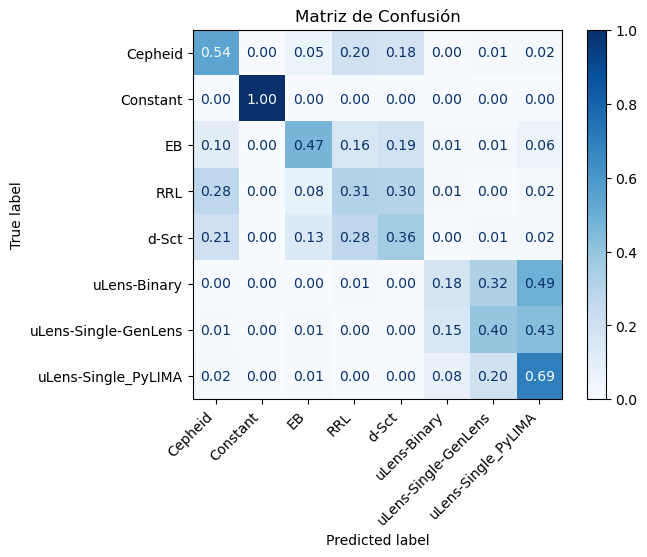

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

def cm(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, values_format='.2f')
    plt.title('Matriz de Confusión')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
best_model = load_model("best_model.h5")
cm(X_test, y_test, best_model, encoder.categories_[0])
cm_uLens(X_test, y_test, best_model)


In [126]:
a=0